# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers.attention.multi_head_attention import activation
import src.dataclass_dummy as dataclass
import src.correlation_coefficient as correlation_coefficient
import src.plot_ts as plot_ts
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import keras_tuner as kt
import tqdm
import warnings

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

2023-08-28 16:45:35.480833: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:45:35.599303: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-28 16:45:35.600112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 16:45:36.203803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Build model

In [2]:
def build_model(lead_time, seq_length, num_features=29):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Conv1D(
            16,
            4,
            activation="relu",
            input_shape=(seq_length, num_features - 1 if lead_time == 0 else num_features),
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(64, activation="relu", return_sequences=False))
    # model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mse", correlation_coefficient.correlation_coefficient],
    )
    return model

# Feature Selection

In [22]:
n_epochs = 100
model_name = "CNN+LSTM"
show_plots = False
climate = "FOCI"
lead_time = 1
seq_length = 23
threshold = 0.01

data = dataclass.Data(lead_time=1, seq_length=12, split=[0.8, 0.1, 0.1])
possible_features = data.possible_features
possible_features = [feat for feat in possible_features if not feat.startswith('month')]
bad_features = []

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

data = dataclass.Data(
    lead_time=lead_time,
    seq_length=seq_length,
    split=[0.8, 0.1, 0.1],
)

x_train = np.array(data.train_input_FOCI)
y_train = np.array(data.train_target_FOCI)

x_val = np.array(data.validation_input_FOCI)
y_val = np.array(data.validation_target_FOCI)

x_test = np.array(data.test_input_FOCI)
y_test = np.array(data.test_target_FOCI)

model = build_model(lead_time, seq_length=seq_length, num_features=29 + 12)

history = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size=16,
    shuffle=True,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[early_callback],
)

predictions = model.predict(x_val, verbose=0)
predictions = predictions.reshape((predictions.shape[0],))
og_mse = mean_squared_error(predictions, y_val)
og_correlation = np.corrcoef(predictions, y_val)[1, 0]
print(f"Baseline performance: The MSE is: {og_mse}, the correlation coefficient is: {og_correlation}")

for feature in possible_features:
    features = [feat for feat in possible_features if feat != feature]

    if 'PREC_SAHEL' not in features:
        features.append('PREC_SAHEL')

    num_features = len(features)
    data = dataclass.Data(
        lead_time=lead_time,
        seq_length=seq_length,
        split=[0.8, 0.1, 0.1],
        feature_list=features,
    )

    x_train = np.array(data.train_input_FOCI)
    y_train = np.array(data.train_target_FOCI)

    x_val = np.array(data.validation_input_FOCI)
    y_val = np.array(data.validation_target_FOCI)

    x_test = np.array(data.test_input_FOCI)
    y_test = np.array(data.test_target_FOCI)

    model = build_model(lead_time, seq_length=seq_length, num_features=num_features + 12)
    history = model.fit(
        x_train,
        y_train,
        epochs=n_epochs,
        batch_size=16,
        shuffle=True,
        verbose=0,
        validation_data=(x_val, y_val),
        callbacks=[early_callback],
    )

    predictions = model.predict(x_val, verbose=0)
    predictions = predictions.reshape((predictions.shape[0],))
    mse = mean_squared_error(predictions, y_val)
    correlation = np.corrcoef(predictions, y_val)[1, 0]

    if mse < og_mse - threshold:
        bad_features.append(feature)

    print(f"Performance without {feature} The MSE is: {mse}, the correlation coefficient is: {correlation}")
        
print(bad_features)

Baseline performance: The MSE is: 0.8935290046938037, the correlation coefficient is: 0.36044809248897713
Performance without AMO The MSE is: 0.8926335781785749, the correlation coefficient is: 0.3608366304617461
Performance without ENSO_12 The MSE is: 0.8736726980892816, the correlation coefficient is: 0.3864984257414194
Performance without ENSO_3 The MSE is: 0.8769463764173016, the correlation coefficient is: 0.38104973837053413
Performance without ENSO_34 The MSE is: 0.8782431025544756, the correlation coefficient is: 0.38055140721752206
Performance without ENSO_4 The MSE is: 0.8700429558500687, the correlation coefficient is: 0.3914020489203515
Performance without NAO_PC The MSE is: 0.8993232812426625, the correlation coefficient is: 0.35113561305185664
Performance without NAO_ST The MSE is: 0.886752212395106, the correlation coefficient is: 0.3672713936641343
Performance without NP The MSE is: 0.8726646823237484, the correlation coefficient is: 0.3857942869044341
Performance witho

In [24]:
bad_features.remove('PREC_SAHEL')

data = dataclass.Data(lead_time=1, seq_length=1, split=[0.8, 0.1, 0.1])
possible_features = data.possible_features
possible_features = [feat for feat in possible_features if not feat.startswith("month")]

n_epochs = 100
show_plots = False
climate = "FOCI"
lead_time = 1
seq_length = 23

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

data = dataclass.Data(
    lead_time=lead_time,
    seq_length=seq_length,
    split=[0.8, 0.1, 0.1],
    feature_list=[feat for feat in possible_features if feat not in bad_features],
)

x_train = np.array(data.train_input_FOCI)
y_train = np.array(data.train_target_FOCI)

x_val = np.array(data.validation_input_FOCI)
y_val = np.array(data.validation_target_FOCI)

x_test = np.array(data.test_input_FOCI)
y_test = np.array(data.test_target_FOCI)

model = build_model(lead_time, seq_length=seq_length, num_features=41 - len(bad_features))
history = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size=16,
    shuffle=True,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[early_callback],
)

predictions = model.predict(x_val, verbose=0)
predictions = predictions.reshape((predictions.shape[0],))
mse = mean_squared_error(predictions, y_val)
correlation = np.corrcoef(predictions, y_val)[1, 0]
print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")

The MSE is: 0.8666415532831628, the correlation coefficient is: 0.3968191013798317


# Sequence Length

100%|██████████| 21/21 [08:43<00:00, 24.92s/it]


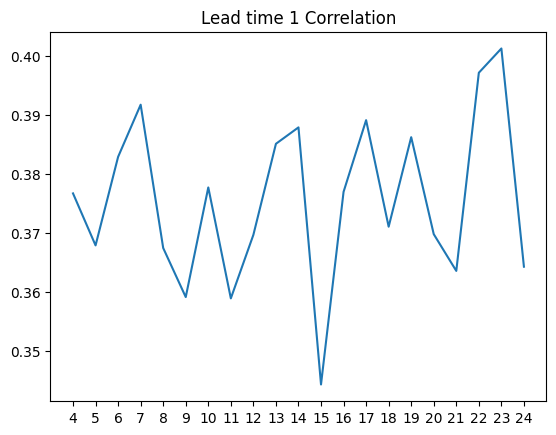

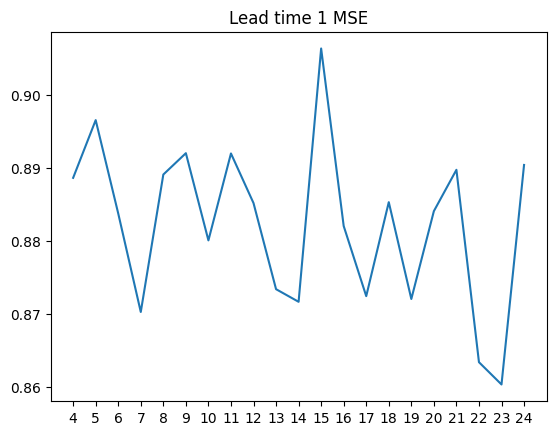

In [17]:
import tqdm

sequence_length = list(range(4, 25))
n_epochs = 100
model_name = "CNN+LSTM"
show_plots = False

climate = 'FOCI'
lead_time = 1

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

results = dict()
histories = dict()
for seq in sequence_length:
    results[f"Lead_time: {lead_time} seq_length: {seq}"] = dict()

for seq in tqdm.tqdm(sequence_length):
    seq_length = seq
    data = dataclass.Data(
        lead_time=lead_time, seq_length=seq_length, split=[0.8, 0.1, 0.1]
    )
    x_train = np.array(data.train_input_FOCI)
    y_train = np.array(data.train_target_FOCI)

    x_val = np.array(data.validation_input_FOCI)
    y_val = np.array(data.validation_target_FOCI)

    x_test = np.array(data.test_input_FOCI)
    y_test = np.array(data.test_target_FOCI)

    model = build_model(lead_time, seq_length=seq_length, num_features=41)
    history = model.fit(
        x_train,
        y_train,
        epochs=n_epochs,
        batch_size=16,
        shuffle=True,
        verbose=0,
        validation_data=(x_val, y_val),
        callbacks=[early_callback],
    )

    predictions = model.predict(x_val, verbose=0)
    predictions = predictions.reshape((predictions.shape[0],))
    mse = mean_squared_error(predictions, y_val)
    correlation = np.corrcoef(predictions, y_val)[1, 0]
    if show_plots:
        print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")
        plot_ts.plot_ts(
            true=data.test_target_CESM,
            predicted=predictions,
            ts_start=10794,
            ts_end=10994,
            title=f"LSTM {climate}, lead time = {lead_time}",
        )
    results[f"Lead_time: {lead_time} seq_length: {seq}"]["Modelname"] = model_name
    results[f"Lead_time: {lead_time} seq_length: {seq}"][f"{climate}_MSE"] = mse
    results[f"Lead_time: {lead_time} seq_length: {seq}"][
        f"{climate}_Correlation"
    ] = correlation
    histories[f"{climate}_{lead_time}"] = history

df = pd.DataFrame.from_dict(results, orient="index")
df

plt.plot(list(range(4,25)), df['FOCI_Correlation'])
plt.xticks(list(range(4,25)))
plt.title(f"Lead time {lead_time} Correlation")
plt.show()

plt.plot(list(range(4,25)), df['FOCI_MSE'])
plt.xticks(list(range(4,25)))
plt.title(f"Lead time {lead_time} MSE")
plt.show()

In [25]:
df

,Modelname,FOCI_MSE,FOCI_Correlation
Lead_time: 1 seq_length: 4,CNN+LSTM,0.888620,0.376689
Lead_time: 1 seq_length: 5,CNN+LSTM,0.896535,0.367899
Lead_time: 1 seq_length: 6,CNN+LSTM,0.883736,0.382866
Lead_time: 1 seq_length: 7,CNN+LSTM,0.870232,0.391686
Lead_time: 1 seq_length: 8,CNN+LSTM,0.889075,0.367457
Lead_time: 1 seq_length: 9,CNN+LSTM,0.892003,0.359161
Lead_time: 1 seq_length: 10,CNN+LSTM,0.880048,0.377696
Lead_time: 1 seq_length: 11,CNN+LSTM,0.891964,0.358940
Lead_time: 1 seq_length: 12,CNN+LSTM,0.885163,0.369683
Lead_time: 1 seq_length: 13,CNN+LSTM,0.873359,0.385074


# Hyperparameter Tuning

In [4]:
def build_model_tuner(hp, lead_time=1, seq_length=23):
    model = tf.keras.models.Sequential()

    cnn_filters = hp.Int("CNN filters", min_value=4, max_value=16, step=2)
    cnn_filter_size = hp.Int("CNN filtersize", min_value=2, max_value=6, step=2)
    dense_units = hp.Int("dense units", min_value=16, max_value=64, step=16)
    
    model.add(
        tf.keras.layers.Conv1D(
            cnn_filters,
            cnn_filter_size,
            activation="relu",
            input_shape=(seq_length, 28 + 12 if lead_time == 0 else 29 + 12),
        )
    )
    # model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.3))
    lstm_units = hp.Int("LSTM units", min_value=32, max_value=64, step=32)
    lstm_layers = hp.Int("LSTM layers", min_value=1, max_value=2, step=1)
    for i in range(lstm_layers):
        if lstm_layers == 1 or i == 1:
            model.add(
                tf.keras.layers.LSTM(
                    lstm_units,
                    activation="relu",
                    return_sequences=False,
                )
            )
        else:
            model.add(
                tf.keras.layers.LSTM(
                    lstm_units,
                    activation="relu",
                    return_sequences=True,
                )
            )
    model.add(tf.keras.layers.Dropout(0.3))
    dense_layers = hp.Int("Dense layers", min_value=0, max_value=2, step=1)
    for _ in range(dense_layers):
        model.add(tf.keras.layers.Dense(dense_units, activation="relu"))
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4])
    learning_rate = 1e-3
    model.compile(
        # optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mse", correlation_coefficient.correlation_coefficient],
    )
    return model

In [7]:
n_epochs = 100
model_path = "./models/"

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, save_weights_only=True, verbose=0
)

lead_time = 1
climate = "FOCI"
seq_length = 23
data = dataclass.Data(lead_time=lead_time, seq_length=seq_length, split=[0.8, 0.1, 0.1])

tuner = kt.Hyperband(
    # build_model_tuner(hp=kt.HyperParameters(), lead_time=lead_time),
    build_model_tuner,
    objective="val_loss",
    max_epochs=100,
    factor=3,
    directory="CNN-LSTM-tuner-new",
    project_name="hyper_tuner_0",
    seed=42
)

x_train = np.array(data.train_input_FOCI)
y_train = np.array(data.train_target_FOCI)

x_val = np.array(data.validation_input_FOCI)
y_val = np.array(data.validation_target_FOCI)

x_test = np.array(data.test_input_FOCI)
y_test = np.array(data.test_target_FOCI)

tuner.search(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size=16,
    shuffle=True,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_callback],
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size=16,
    shuffle=True,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[early_callback],
)

predictions = model.predict(x_val, verbose=0)
predictions = predictions.reshape((predictions.shape[0],))
mse = mean_squared_error(predictions, y_val)
correlation = np.corrcoef(predictions, y_val)[1, 0]
print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")
if True:
    plot_ts.plot_ts(
        true=data.test_target_CESM,
        predicted=predictions,
        ts_start=10794,
        ts_end=11998,
        title=f"CNN-LSTM {climate}, lead time = {lead_time}",
        persist=False,
        html_title=f"./html_files/complete_CNN-LSTM_{climate}_{lead_time}.html",
    )

INFO:tensorflow:Reloading Tuner from CNN-LSTM-tuner-new/hyper_tuner_0/tuner0.json
INFO:tensorflow:Oracle triggered exit
The MSE is: 0.8864848238427371, the correlation coefficient is: 0.37034688856648773


In [31]:
print(best_hps.get('dense units'))
print(best_hps.get('LSTM units'))
print(best_hps.get('LSTM layers'))
print(best_hps.get('Dense layers'))
print(best_hps.get('CNN filters'))
print(best_hps.get('CNN filtersize'))

64
32
1
0
10
4
